<a href="https://colab.research.google.com/github/akin-oladejo/can-anomaly-detection-v2/blob/main/notebooks/2_Attack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Attacks on CAN Data

## The Task
The Controller Area Network (CAN) is currently the most widely-used in-vehicle networking protocol. CAN is a bi-directional, multi-master, serial bus that uses UTP cabling to ensure reliability in electromagnetically noisy environments.
It provides an effective method for the components of a vehicle called the Electronic Control Units (ECU) to communicate among themselves, as opposed to traditional point-to-point wiring. It is also used in industrial applications as the basis for Devicenet, reducing the wiring needed between a control system and I/O devices.

While it provides a means to communicate reliably, CAN is not known for security. Modern vehicles allow you to plug in devices that can communicate on this network through the OBD-II port or some other port like the USB. Also, some of the devices in modern vehicles that use the CAN are connected to the internet, allowing external attacks in various forms. These attacks include Replay, Spoofing, Denial of Service (DOS) and so on.  

The task in this project is to **detect attacks on the CAN**.  
  
This will be done using different methods. The methods are:
1. Frequency-based detection  
Frequency-based methods use the increase in CAN transmission during attacks as the heuristic for detection.
2. Payload-based detection  
Payload-based methods read the data that is transmitted and detect when the data is unusual or unexpected. I will implement two payload-based detection models, one using the Isolation Forest algorithm (tree-based anomaly detection) and the second using an autoencoder (reconstruction error).



In [ ]:
# Import libraries for this task

# data analysis libs
import pandas as pd
import numpy as np

# visualization libs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning libs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import torch as T

# utils
from dataclasses import dataclass
import joblib
from tqdm import tqdm
from collections import Counter
import json
import warnings
from datetime import timedelta

In [ ]:
# config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_palette("RdPu")
warnings.filterwarnings('ignore')

# seed for PRNG's
rs = 42
np.random.seed(rs)
T.manual_seed(rs)

## The Dataset
The dataset used in this project is the **Real ORNL Automotive Dynamometer (ROAD) CAN Intrusion Dataset**, from (Verma et al., 2020). It can be found [here](https://0xsam.com/road/). The dataset consists of over 3.5 hours of an (unspecified) vehicle’s CAN data. ROAD contains ambient data recorded during a diverse set of activities, and attacks of increasing stealth with multiple variants and instances of real fuzzing, fabrication, and unique advanced attacks, as well as simulated masquerade attacks. In the paper, the authors discuss that the purpose of the dataset is to provide a CAN benchmark dataset free of the problems of previous public datasets such as the lack of comparability and the inconsistency of CAN message intervals due to the insertion of synthetic data post-recording.

The dataset consists of three folders: ambient, attacks and signal extractions.

Ambient data is ground truth — a recording of CAN transmission in the vehicle during regular (attack-free) driving. Several log files are provided but each log is either a recording of highway driving or on a dynamometer (dyno, for short).

The signal extractions folder contains the same CAN data found in the ambient and attack folders, except that the signals have already been translated from hexadecimal to decimal numbers.

The attacks in the dataset are:
1. **Accelerator attack**   
This is an exploit of a vulnerability particular to the vehicle the authors tested. The CAN data of the exploit is not given, rather the CAN transmission as the vehicle suffers the exploit. Because of its uniqueness, this attack is not included in the data I used to train the intrusion detection systems.
2. **Correlated signal attack**  
The single ID message communicating the four wheels’ speeds (each is a two-byte signal) is injected with four false wheel speed values that are all pairwise very different. This effectively kills the car— it rolls to a stop and inhibits the driver from effecting acceleration, usually until the car is restarted.
3. **Fuzzing attack**  
The authors mounted the less stealthy version of the fuzzing attack, injecting frames with random IDs (cycling in order from 0x000 to 0x255) with maximum payloads (0xFFFFFFFFFFFFFFFF) every .005s (as opposed to only injected IDs seen in ambient data). Many physical effects of this attack were observed—accelerator pedal is impotent, dash and lights activated, seat positions move, etc. By injecting messages with maximal payload, the authors prevented incidental ECU bus-off. With the exception of the accelerator attack, every other attack targets an ID.
4. **Max engine coolant temperature attack**  
The authors target the engine coolant signal (one byte), modifying the signal
value to be the maximum (0xFF). The result is that the “engine coolant too high” warning light on the dashboard turns on.
5. **Max speedometer attack**  
The speedometer signal (one byte) is targeted. The authors modified this signal value to be the maximum (0xFF), causing the speedometer to falsely display a maximum value.
6. **Reverse light attacks**
A binary (one bit) signal communicating the state of the reverse lights (on/off) is targeted. The authors perform two slight variations of the attack, where they manipulate the value to off while the car is in Reverse or on when the car is in Drive. The consequence is that the reverse lights do not reflect what gear the car is using.

For all attacks except the accelerator attack, both original fabrication and masquerade versions were provided by the authors. The Fabrication attacks are the attacks as they took place in ***flam*** fashion. Flam attacks, introduced by Hoppe, Kiltz, and Dittmann (2011), are a clever way to game the Controller Area Network by injecting malicious data <ins>immediately</ins> after authentic ID transmission so that malicious data can be read as though it came from the valid ID. The indirect effect is that there are more messages transmitted during attacks. This side effect is why the first approach I will use, the frequency-based detection, may be effective at detecting attacks.

The masquerade version contained only the spoofed data when attacks occurred, because the authors performed some post-processing to remove the normal transmission of the targeted ID's, without violating the CAN protocol. Note that for masquerade attacks, frequency-based methods are not likely to work.

For training, tuning and testing, fabrication (flam) data will be used.

In [ ]:
# uncomment outside of colab
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/datasets/road_data'

Mounted at /content/drive


In [ ]:
# store the locations of the datasets
# data_path = 'data'
with open(f'../{data_path}/metadata.json', 'r') as f:
    dataset = json.load(f)

dataset.keys() # print keys

dict_keys(['train', 'test', 'validation'])

In [ ]:
# view attacks in test folder
dataset['test'].keys()

dict_keys(['correlated_signal_attack', 'fuzzing_attack', 'max_speedometer_attack', 'reverse_light_off_attack', 'reverse_light_on_attack'])

In [ ]:
# view attacks in validation folder
dataset['validation'].keys()

dict_keys(['correlated_signal_attack', 'fuzzing_attack', 'max_speedometer_attack', 'reverse_light_off_attack', 'reverse_light_on_attack'])

## Preprocessing the data: the `ROADPrep` and `ArbitrationEncoder` classes
For the analysis of the data that inspires the preprocessing in the `ROADPrep` class, check [the analysis notebook](notebooks/1_CAN_Analysis.ipynb).  

### `ROADPrep`  
The `ROADPrep` class contains methods to process the data into valid input for machine learning algorithms. At instantiation, ground truth (used for training) and test data are loaded using their paths specified in the provided [metadata file](data/metadata.json). This is done by the `load_csv()` method. The ground truth data used is a 7-minute run of the vehicle on a dynamometer with no attack injections loaded from the. The other data are different dyno runs with the different attacks, loaded from the test, train and masquerade folders. The paths to the log files are given in the metadata file.

The `load_csv()` method calls the `prep()` method where the actual preprocessing is done. The following steps are performed:
1. arbitration ID is extracted and scaled using the custom class, `ArbitrationEncoder`
2. The data is extracted. It is split into 8 features and eny missing data is filled with the default hex of `00`. The hex data is thereafter converted to float values and scaled.
3. The timestamp information is extracted. It is parsed from float to datetime for use as the index in the preprocessed data
4. When an object of `ROADPrep` is instantiated, an argument, `add_interval_feature`, may be passed. If set to `True`, a new feature `interval`, containing the time in between can messages for each is log is created, scaled and concatenated with the rest of the preprocessed data.
5. For each attack dataset, a temporary array containing nothing but `0` is created. Attack rows are later changed to `1` using the `label_attacks()` method using injection interval information found in the metadata file.

Note that the scalers and encoder are trained on the train data and then used to transform both train and attack data.


### `ArbitrationEncoder`
The `ArbitrationEncoder` class is a simple encoder written to preserve the priority of ID values used as arbitration values by mapping hex values to decimal, as opposed to one-hot encoding the hex strings representing the arbitration ID. For context, the lower the ID, the higher the priority of a message in the CAN protocol. Consult [this article](https://copperhilltech.com/blog/controller-area-network-can-bus-bus-arbitration/) for a more detailed explanation of the idea of message arbitration.

Another reason this class was custom written is to be able to assign a default value to previously unseen ID values. During the preprocessing, possibly malicious ID's will be mapped to the same value.

The `fit()` method stores valid ID values and computes the standard deviation and mean of the dataset. The `transform()` method uses this information to convert valid ID's to their corresponding float and invalid ID's to the default value discussed earlier. This value, `unknown_value`, is passed at instantiation. Finally, the `transform()` method normalizes the data, using the standard deviation and mean  computed during the `fit()` step.

For convenience, a `fit_transform()` method is implemented that runs both methods at once.



In [ ]:
class ArbitrationEncoder():
    """
    Convert arbitration Id's into floats and normalize them. During transformation,
    previously unseen id's are stored using an unknown_value parameter that is either
    passed during instantiation or calculated as the negative of the number of unique valid ID's

    Example
    =======
    >>> enc = ArbitrationEncoder(unknown_value = -150)
    >>> enc.fit(df['arbitration_id'])
    >>> enc.transform(test_df['arbitration_id'])
    """
    def __init__(self, unknown_value:int|None=None):
        self.valid_ids = {}
        self.unknown_value = unknown_value if unknown_value else None

    @np.vectorize
    def make_float(self, val):
        """Convert hex to float"""
        return float(int(val, base=16)) # convert to float

    def fit(self, train_ids):
        """
        Determine the unique elements, standard deviation and mean of the input array.
        Also, calculate default value for unseen ID's if not passed at instantiation
        """
        # if isinstance(train_ids, pd.DataFrame):
        #     train_ids = arr.values
        self.valid_ids = set(train_ids) # get unique train id's
        self.converted_valid_ids = self.make_float(self,train_ids)
        self.std = np.std(self.converted_valid_ids) # calculate std
        self.mean = np.mean(self.converted_valid_ids) # calculate mean
        if not self.unknown_value:
            self.unknown_value = -(len(self.valid_ids))

    @np.vectorize
    def convert_and_scale(self, val):
        """
        Normalize array (compute the z-score). Note that all previously unseen values have the
        same transformation since `unknown_value` is a constant.
        """
        if not val in self.valid_ids:
            return (self.unknown_value - self.mean)/self.std
        else:
            converted_id = self.make_float(self, val) # convert from hex to float
            return (converted_id - self.mean)/self.std #return z score

    def transform(self, arr):
        """
        Transform array after running the `fit()` method
        """
        return self.convert_and_scale(self, arr)

    def fit_transform(self, arr):
        self.fit(arr)
        return self.transform(arr)

In [ ]:
# define preprocessor class
class ROADPrep():
    def __init__(self,
                 *,
                 dataset_path:str = data_path,
                 load_attack_from:str,
                 add_interval_feature:bool = True
                ):
        """
        Load and preprocess datasets; load standard scaler and one-hot encoder

        Parameters
        ==========
        dataset_path: str. Path to the dataset
        load_attack_from: str. Possible values are {'train', 'test', 'validation'}
        """
        # to avoid wasting time, if load_attack_from argument is wrong, raise error
        if load_attack_from not in ['test', 'validation']:
            raise ValueError("Valid arguments for 'load_attack_from' parameter are 'test' and 'validation'")

        self.dataset_path = dataset_path
        self.message_scaler = StandardScaler()
        self.arbitration_encoder = ArbitrationEncoder()
        self.load_attack_from = load_attack_from

        # create a boolean and scaler for the interval feature if `add_interval_feature` == True
        if add_interval_feature:
            self.add_interval_feature = add_interval_feature
            self.interval_scaler = StandardScaler()

        # load and preprocess train dataset
        train_path = dataset['train']['path']
        self.train = self.load_csv(train_path, is_train=True) # generate train dataset

        # load and preprocess attack datasets, generate temporary labels of 0 for attack and normal data
        self.correlated_signal_attack_X, self.correlated_signal_attack_y = self.load_csv(dataset[self.load_attack_from]['correlated_signal_attack']['path'])
        self.fuzzing_attack_X, self.fuzzing_attack_y = self.load_csv(dataset[self.load_attack_from]['fuzzing_attack']['path'])
        self.max_speedometer_attack_X, self.max_speedometer_attack_y = self.load_csv(dataset[self.load_attack_from]['max_speedometer_attack']['path'])
        self.reverse_light_off_attack_X, self.reverse_light_off_attack_y = self.load_csv(dataset[self.load_attack_from]['reverse_light_off_attack']['path'])
        self.reverse_light_on_attack_X, self.reverse_light_on_attack_y = self.load_csv(dataset[self.load_attack_from]['reverse_light_on_attack']['path'])

        # finally, label attack data
        self.label_all_attacks()

    def load_csv(self, file_path:str, is_train:bool = False)->tuple|pd.DataFrame:
        """Read csv into dataframe and add headers"""
        df = pd.read_csv(data_path+file_path,
                         delimiter=' ',
                         names=['timestamp', '_', 'id_and_message'])

        return self.prep(df, is_train) # preprocess the df for model building

    def prep(self, df, is_train)->tuple|pd.DataFrame:
        """
        Encode categorical and Numeric features; scale numeric features;
        parse timestamp
        """
        id_and_message = df['id_and_message'].str.split('#', expand=True)

        # extract arbitration ID
        arbit_id = id_and_message[0].values # extract the arbitration ID

        # extract CAN packet data, convert to float and scale
        message = id_and_message[1].apply(lambda x: ' '.join(x[i:i+2] for i in range(0, len(x), 2))) # space out
        message = message.str.split(' ', expand=True) # split message into 8 features
        message.fillna('00', inplace=True) # pad short messages with 00 to make 8 features
        message = message.apply(lambda x : x.astype(str).map(lambda x : float(int(x, base=16)))) # convert hex values to float

        timesteps = df['timestamp'].apply(lambda x: x.strip('()')).astype('float').values # strip parentheses, parse to float
        if self.add_interval_feature:
            # shift the timesteps by one element and pad it at the end with the last value so a difference can be calculated
            shifted_timesteps = np.append(timesteps[1:], timesteps[-1])
            interval = (shifted_timesteps - timesteps).reshape(-1, 1) # add interval feature

        # parse the timestamp to datetime for use as an index
        time_index = pd.Series(pd.to_datetime(timesteps, unit='s'), name='timestamp') # convert epoch to datetime

        if is_train:
            # if this is train data, fit the encoders before transforming data
            arbit_id = self.arbitration_encoder.fit_transform(arbit_id) # fit and transform the arbitration_id in the train data
            message = self.message_scaler.fit_transform(message) # fit and transform `message` features
            if self.add_interval_feature:
                # fit_transform interval; concatenate message, interval and id
                interval = self.interval_scaler.fit_transform(interval)
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(interval), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)
            else:
                # concatenate message and id only
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)

            # return train data only as there are no labels
            return data

        else:
            # if this is not train data, only transform the data. do not fit encoders
            arbit_id = self.arbitration_encoder.transform(arbit_id)
            message = self.message_scaler.transform(message)
            if self.add_interval_feature:
                # transform interval; concatenate message,interval and id
                interval = self.interval_scaler.transform(interval)
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(interval), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)
            else:
                # concatenate message and id only
                data = pd.concat([pd.DataFrame(message), pd.DataFrame(arbit_id)], axis=1).set_index(time_index)

            # `is_train` being False means this is an attack dataset, thus generate a temporary label series with all values being 0.
            # Attack timestamps in the label will be changed to 1 by the label_attack() method
            dummy_label = pd.Series(np.zeros(data.shape[0], dtype='int'), index=data.index)
            return data, dummy_label


    def label_attack(self, attack_data, attack_name:str):
        """
        Obtain the attack interval bounds from the metadata.json file and convert to datetime

        Parameters
        ==========
        attack_data: pd.Series. The temporary label to update
        attack_name: str. The name of the attack data so it can be searched up in the metadata file
        """
        # get attack interval in seconds
        attack_start_s, attack_stop_s = dataset[self.load_attack_from][attack_name]['injection_interval'] # interval bound

        # get start time in seconds
        record_start = attack_data.index[0]

        # label interval in timestamps by calculating the attack interval
        attack_start_t = record_start + timedelta(seconds=attack_start_s)
        attack_stop_t = record_start + timedelta(seconds=attack_stop_s)

        attack_data.loc[attack_start_t:attack_stop_t]=1 # replace 0's with 1's

        return attack_data


    def label_all_attacks(self):
        """Label attack timestamps in the attack datasets using the intervals provided in the metadata.json"""
        self.correlated_signal_attack_y = self.label_attack(self.correlated_signal_attack_y, 'correlated_signal_attack')
        self.fuzzing_attack_y = self.label_attack(self.fuzzing_attack_y, 'fuzzing_attack')
        self.max_speedometer_attack_y = self.label_attack(self.max_speedometer_attack_y, 'max_speedometer_attack')
        self.reverse_light_off_attack_y = self.label_attack(self.reverse_light_off_attack_y, 'reverse_light_off_attack')
        self.reverse_light_on_attack_y = self.label_attack(self.reverse_light_on_attack_y, 'reverse_light_on_attack')

Great, let's create the datasets that will be used to test and validate the flam attacks.

In [ ]:
road_test = ROADPrep(load_attack_from='test') # dataset for training

In [ ]:
road_valid = ROADPrep(load_attack_from='validation') # dataset for validation

Take a look at some of the data after preprocessing

In [ ]:
road_test.train.head(3)

,0,1,2,3,4,5,6,7,0,0
timestamp,,,,,,,,,,
2002-08-22 07:06:40.000000000,-0.742562,-0.693366,-0.721381,-0.726897,2.262620,-0.501874,2.015894,1.644356,-0.664669,-0.621172
2002-08-22 07:06:40.000002048,-0.742562,-0.584288,2.388608,-0.275816,-0.762142,-0.153693,0.841268,1.069590,-0.666383,-0.813723
2002-08-22 07:06:40.000002944,-0.742562,-0.802445,-0.721381,-0.764487,-0.775124,-0.729530,-0.850194,-0.929597,-0.666192,3.230873


In [ ]:
road_test.reverse_light_on_attack_X.head(3)

,0,1,2,3,4,5,6,7,0,0
timestamp,,,,,,,,,,
2008-12-23 02:40:00.000000000,-0.742562,-0.802445,-0.721381,-0.764487,-0.775124,-0.729530,-0.850194,-0.929597,-0.666383,3.230873
2008-12-23 02:40:00.000001024,1.361875,-0.802445,-0.323302,-0.764487,2.483310,0.984589,-0.850194,-0.917102,-0.666383,0.225228
2008-12-23 02:40:00.000001792,1.218391,0.356514,-0.335742,1.591158,0.626911,0.020397,-0.368597,-0.354831,-0.666002,0.003846


## An Overview of the Methods
All three methods will solve the problem of intrusion detection by framing it as a <ins>novelty detection</ins> problem. With novelty detection, any data point that does not conform to the properties of data the algorithm was presented with during training is considered novel (in this case, an attack).

### Why novelty detection?
The problem with attack data is that they resemble normal data, making them difficult to detect. Consider the following attacks:
- Denial of Service (DOS)  
A DOS attack occurs when data is transmitted so many times using a high priority ID e.g `0`, so that proper functioning of the CAN is inhibited. The payload may even be regular signals, even if the ID is not regularly seen.
- Replay attack  
 A replay attack is the repeated transmission of data from a single ID to fool the protocol, launch a masquerade attack etc. The ID and payload may be valid, however the ECU has been compromised.

This presents a question — how does an algorithm tell this kind of data apart from regular, normal data? The answer to this question is a principle backing many implementations of CAN intrusion detection systems in research: the context of attack transmission is different from regular transmission. Here are some context clues for when there is an attack:
1. Usually, attacks *increase CAN transmission rates*. This is demonstrated in (Young, Olufowobi, Bloom & Zambreno, 2019) and is in fact the basis of method 1.
2. Some arbitration ID's *are not seen as often*, or even ever. Perhaps an increase in transmission rates from an ID indicates an anomaly. What happens when an arbitration ID that never transmits normally suddenly starts transmitting? Will that help identify anomalies?
3. Attack data can *contain weird payloads*. Take for instance the fuzzing and targeted ID attacks.

Methods 2 and 3 operate using the second and third context clues. It is therefore reasonable to study the context of regular transmission and use these clues to discriminate the transmission of attacks. Hence, the framing of the problem as novelty detection.

## Scoring and Testing the methods
It is not enough that a method detects anomalies. If the model were to predict wrongly most of the time, it would be annoying. We want the model to detect as many anomalies but not to the point where there are so many spurious detections. Hence we want a model that scores a high true positive rate for the attack class and a low false positive rate so we don't have an incessant detector. We want a model that balances precision and recall. Thus, the F1 score is a good metric.



### A Pattern to the Three Approaches
For uniformity, each method will be modeled as a class that implements the following methods:
- `__init__()`  
While the different methods may create different attributes and call different methods upon object initialization, the different classes initialize a common attribute: `attack_f1`. `attack_f1` is a dictionary to store the F1 scores of each model on the different attack datasets. These values are visualized using the `chart_f1()` method.
- `fit()`  
The different methods follow a common principle: learn the representation of normal activity. The `fit` method learns this representation differently for each method: for method 1 (message frequency detection), it learns the normal rate; for method 2 (isolation forest), it learns anomaly scores by recursively partitioning data. for method 3 (autoencoder), it learns a latent representation of normal data to arrive at a consistent error of reconstruction.
- `detect_anomalies()`  
This method uses the model's internal representation of normal data to detect an anomaly. When predictions have been made, it prints the classification report and stores the F1 score of the model on the target class in the model's `attack_f1` attribute.
- `chart_f1()`  
Each model defines a `chart_f1()` method to visualize the performance of the model on the different attack datasets as a barplot of F1 values.

The uniformity of the three methods allows us to define a single testing function, `test_method`, that runs the `detect_anomalies()` method for each attack type and visualizes their F1 scores:

In [ ]:
def test_method(model,
                  dset:ROADPrep,
                  print_report:bool=False):

    attack_dict = {
        'Correlated Signal':{
            'test':dset.correlated_signal_attack_X,
            'label':dset.correlated_signal_attack_y
        },

        'Fuzzing':{
            'test':dset.fuzzing_attack_X,
            'label':dset.fuzzing_attack_y
        },

        'Max Speedometer':{
            'test':dset.max_speedometer_attack_X,
            'label':dset.max_speedometer_attack_y
        },

        'Reverse Light Off':{
            'test':dset.reverse_light_off_attack_X,
            'label':dset.reverse_light_off_attack_y
        },

        'Reverse Light On':{
            'test':dset.reverse_light_on_attack_X,
            'label':dset.reverse_light_on_attack_y
        },
    }

    for attack_name, data in attack_dict.items():
        preds = model.detect_anomalies(data['test'],
                                      data['label'],
                                      attack_name=attack_name,
                                      print_report=print_report,
                                      return_preds=print_report) # return the predictions

        if print_report:
            print(f"Predictions for '{attack_name}' attack:")
            print(Counter(preds))
            print('\n=================================================================')

    print(f'\nF1 Scores of the {model.model_name_} method:')
    for i, j in model.attack_f1.items():
        print(f'{i:<20}: {round(j,5)}')

    print()
    model.chart_f1() # display f1 as barplot

## Method 1: Frequency-based Detection
Young, Olufowobi, Bloom & Zambreno (2019) propose that a more than double increase in the frequency of CAN message transmission is a simple indicator that there are anomalies in a CAN bus.

To implement this idea, a class, `Freq`, is defined. It defines a window (here, one second) and determines the average number of normal messages transmitted in that window. At inference time, if the frequency is greater than a given threshold, there is an anomaly. Remember the first context clue?

Note that this method only cares about *how many* messages were transmitted in each window and not what those messages were. For this, a dummy feature containing only the numeric value `1` is created and used to count the number of messages per second.

That average number of messages per second during normal CAN transmission is stored as `normal_rate` and then used in anomaly detection at inference time.

In [ ]:
class Freq:
    def __init__(self, threshold):
        self.normal_rate:float|None = None
        self.confusion_matrix = None
        self.threshold = threshold
        self.model_name_ = 'Frequency Detection'

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def get_freq(self, df):
        """Obtain the frequency of CAN messages for each second"""
        # replace the data with a counting column but retain the timestamps
        df = pd.concat([pd.Series(df.index),
                        pd.Series(np.ones(df.shape[0]), name='message_count')], axis=1)

        # group by second
        freqs = df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).count()

        return freqs

    def fit(self, train_X:pd.DataFrame):
        """Obtain the normal rate by calculating average frequency of normal messages"""
        print("\nStarting training")
        self.train_freqs = self.get_freq(train_X)
        self.normal_rate = self.train_freqs[1:-1].mean()
        print('Training complete')

    def predict(self, test_X:pd.DataFrame):
        self.test_freqs = self.get_freq(test_X)
        preds = (self.test_freqs > (self.threshold * self.normal_rate)).astype(int)
        return preds.loc[:,'message_count'].values

    def transform_labels(self, labels):
        """Transform the label by grouping by second"""
        label_df = labels.reset_index()
        labels = label_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).any().astype(int)
        # labels = label_df.groupby(pd.Grouper(key='timestamp', axis=0, freq='S')).sum()

        return labels

    def detect_anomalies(self, test_X, test_labels, attack_name, print_report=True, return_preds=False):
        labels = self.transform_labels(test_labels)

        # instantiate isolation forest model
        preds = self.predict(test_X)
        if print_report:
            print(f'Performance of the {self.model_name_} method on {attack_name} attack:')
            print(classification_report(labels, preds))

        self.attack_f1[attack_name] = f1_score(labels, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

When we call the `detect_anomalies` method of the `Freq` class above:
- the `normal_rate` is obtained from training data
- predictions are made using the `normal_rate` and the test data. Note that predictions show whether an anomaly occurred at a given second.
- the actual labels are processed into windows of one second so they indicate an anomaly occurred at a given second. This allows for comparison.
- the classification report is printed

In [ ]:
# initialize the model on training data to get a value for normal rate
freq = Freq(threshold=2)
freq.fit(road_test.train)
print(f'Normal rate of CAN transmission: {freq.normal_rate}')


Starting training
Training complete
Normal rate of CAN transmission: message_count    2391.507901
dtype: float64


Let's test the frequency detection method


F1 Scores of the Frequency Detection method:
Correlated Signal   : 0.0
Fuzzing             : 0.0
Max Speedometer     : 0.0
Reverse Light Off   : 0.0
Reverse Light On    : 0.0



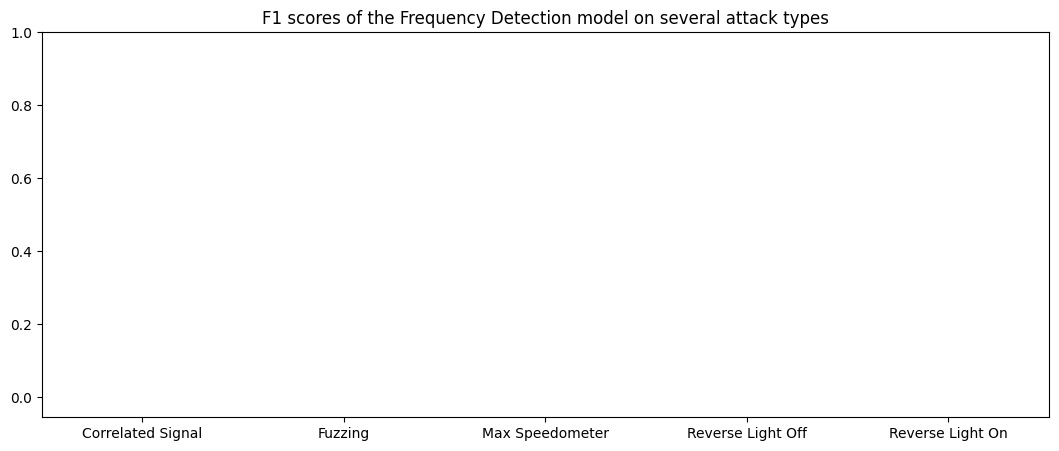

In [ ]:
test_method(model=freq,
              dset=road_test,
              print_report=False)

#### Hyperparameter Tuning
The authors' decision to make the threshold `2` (meaning that when the transmission rate doubles, there is an attack) may have been influenced by the nature of attacks they studied: synthetic injection attacks added in post-processing. It will be useful to use a more lenient value for threshold.   
  
Let's set the threshold value to 1.003 (so if there are on average 1405 messages per second, 1410 messages in a single second will indicate an attack). The tuning will be done on the same test data but evaluated against the validation data to avoid data leakage.

In [ ]:
# initialize the model on training data to get a value for normal rate
freq2 = Freq(threshold=1.003)
freq2.fit(road_test.train)
print(f'Normal rate of CAN transmission: {freq2.normal_rate}')


Starting training
Training complete
Normal rate of CAN transmission: message_count    2391.507901
dtype: float64



F1 Scores of the Frequency Detection method:
Correlated Signal   : 0.97674
Fuzzing             : 0.66667
Max Speedometer     : 1.0
Reverse Light Off   : 1.0
Reverse Light On    : 0.97674



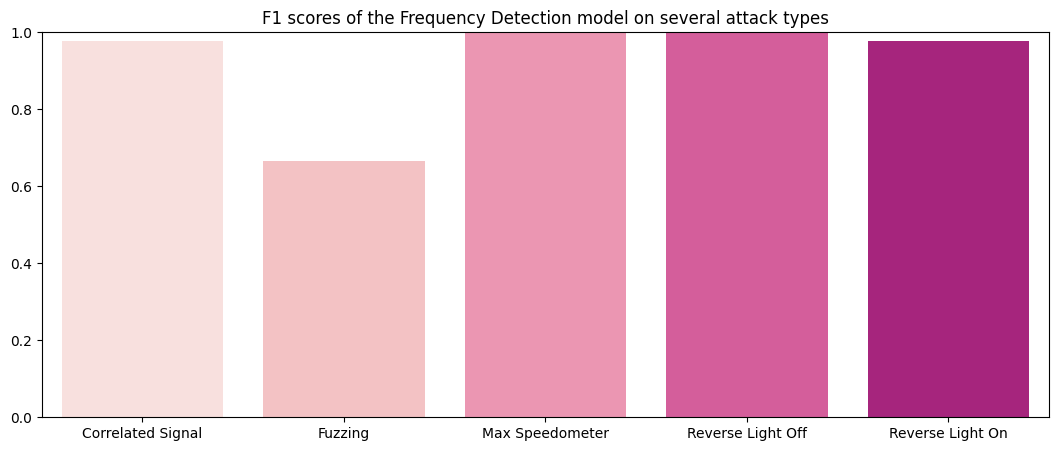

In [ ]:
test_method(model=freq2,
              dset=road_test,
              print_report=False)

Great choice of threshold. Let's evaluate with the validation data

Performance of the Frequency Detection method on Correlated Signal attack:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.96      0.98        23

    accuracy                           0.97        29
   macro avg       0.93      0.98      0.95        29
weighted avg       0.97      0.97      0.97        29

Predictions for 'Correlated Signal' attack:
Counter({1: 22, 0: 7})

Performance of the Frequency Detection method on Fuzzing attack:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.67      0.80         3

    accuracy                           0.93        14
   macro avg       0.96      0.83      0.88        14
weighted avg       0.93      0.93      0.92        14

Predictions for 'Fuzzing' attack:
Counter({0: 12, 1: 2})

Performance of the Frequency Detection method on Max Speedometer attack:
       

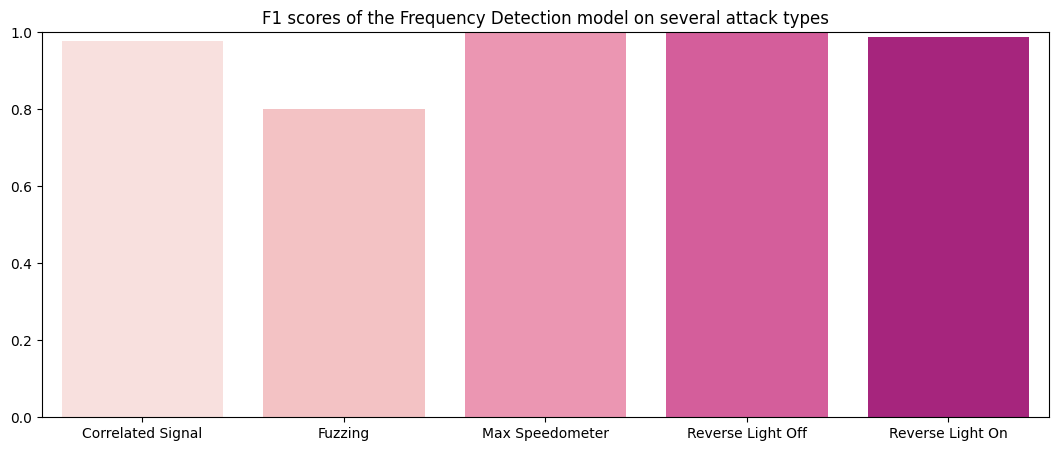

In [ ]:
test_method(model=freq2,
              dset=road_valid, # use validation data
              print_report=True)

## Method 2: Tree-based Anomaly Detection
One popular unsupervised algorithm for anomaly/novelty detection is the Isolation Forest proposed by Liu, Ting, & Zhou (2008). It works by computing the anomaly score of data points as the number of times it is partitioned. It considers as outliers the samples that have a low anomaly score.

Isolation Forest performs the following steps to detect an anomaly:
1. recursively partition the data into smaller and smaller subsets
2. at each step, a random feature and a random split value are chosen
3. the anomaly score for each data point is calculated as the number of times a data point is partitioned
4. data points with lower anomaly scores are more likely to be anomalies.

Let's implement an Isolation Forest class that inherits the original class in `sklearn`:

In [ ]:
class IsoForest(IsolationForest):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.attack_f1 = dict() # store f1 scores for visualization later
        self.model_name_ = 'Isolation Forest'

    def fit(self, train_X):
        print("\nStarting training")
        super().fit(train_X)
        print('Training complete')

    def detect_anomalies(self, test_X, label, attack_name, print_report=True, return_preds=False):
        # contam = label.sum()/label.shape[0] # get the fraction of anomalies
        # make predictions and print classification
        preds = super().predict(test_X)
        preds = np.where(preds==1, 0, 1) # transform predictions using {-1:1, 1:0}
        if print_report:
            print(f'Performance of the {self.model_name_} approach on {attack_name}:')
            print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

Note that the predictions of the model had to be transformed using the mapping {-1:1, 1:0} because the `predict` method of `sklearn.IsolationForest` returns -1 for anomalies and 1 for inliers. The transformation was necessary so that it could correspond to the label in the dataset with 0 representing normal data and 1 representing anomalies.

In [ ]:
isof = IsoForest()
isof.fit(road_test.train) # fit model


Starting training
Training complete


Let's test the density-based approach


F1 Scores of the Isolation Forest method:
Correlated Signal   : 0.53066
Fuzzing             : 0.2586
Max Speedometer     : 0.34051
Reverse Light Off   : 0.32797
Reverse Light On    : 0.40323



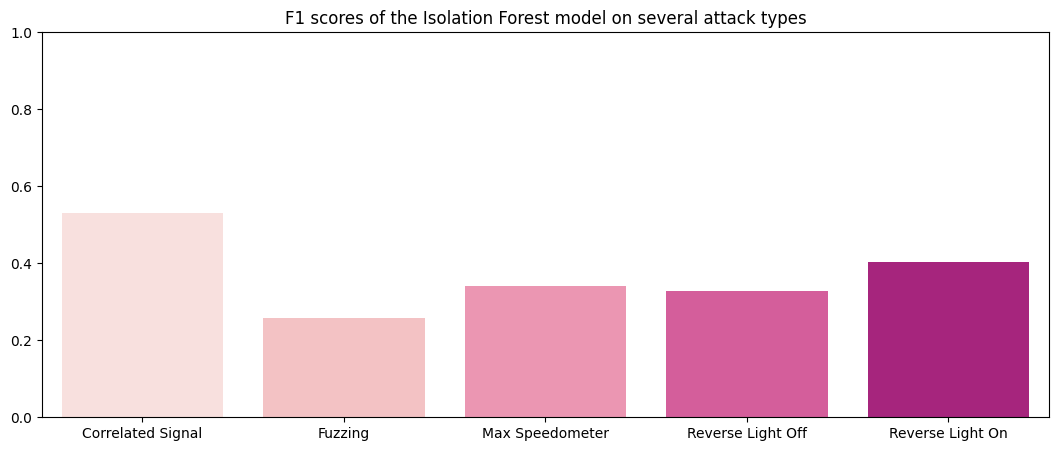

In [ ]:
test_method(model=isof,
              dset=road_test,
              print_report=False)

### Hyperparameter Tuning
The `IsolationForest` implementation in sklearn has several hyperparameters including
- `n_estimators`: the number of base estimators in the ensemble  
- `max_samples`: the number of samples to draw from X to train each base estimator.
- `max_features`: the number of features to draw from X to train each base estimator.

To tune this model, the `HalvingGridSearchCV` will be used. `HalvingGridSearchCV` is an elimination variant of the exhaustive Grid Search which excludes poor performing hyperparameter combinations in successive stages like a tournament. Using this search method across the given hyperparameter space, we are able to save time and computation resources as opposed to using `GridSearchCV`.

Note that there will be a slight workaround for the tuning step: all attack data in the test folder will be used for tuning. After tuning, the updated `IsolationForest` will be tested on all the attacks in the validation set. This means concatenating the attack data.


First, let's concatenate the attack data in the test folder

In [ ]:
road_test_X = [road_test.correlated_signal_attack_X,
road_test.fuzzing_attack_X,
road_test.max_speedometer_attack_X,
road_test.reverse_light_off_attack_X,
road_test.reverse_light_on_attack_X]

road_test_y = [road_test.correlated_signal_attack_y,
road_test.fuzzing_attack_y,
road_test.max_speedometer_attack_y,
road_test.reverse_light_off_attack_y,
road_test.reverse_light_on_attack_y]

# concatenate
X = pd.concat(road_test_X, axis=0)
y = pd.concat(road_test_y, axis=0)

# print shapes
print(f"Shapes\nX:{X.shape}\ny:{y.shape}")

Shapes
X:(545140, 10)
y:(545140,)


In [ ]:
# for faster results, switch min_resources from 'exhaust' to a small number e.g 10000
param_grid = {'n_estimators':[100, 200, 300],
              'max_samples':[0.25, 0.5, 0.75, 1.0],
              'max_features':[0.25, 0.5, 0.75, 1.0]
              }

base_estimator = IsolationForest()
hs = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, min_resources=15000,
                         scoring=f1_score, n_jobs=-1).fit(X, y) # use at least 100,000 samples for each candidate

In [ ]:
print(f"Number of samples used at each stage: {hs.n_resources_}")
print(f"Number of candidates at each stage: {hs.n_candidates_}")

Number of samples used at each stage: [15000, 30000, 60000, 120000, 240000, 480000]
Number of candidates at each stage: [48, 24, 12, 6, 3, 2]


In [ ]:
hs.best_estimator_

IsolationForest(max_samples=1.0, n_estimators=200)

The hyperparameter search reveals a combination of `max_samples=1` and `n_estimators=200` to be the best provided candidate for the combined dataset. Let's see how it performs on the test set:

In [ ]:
isof2 = IsoForest(max_samples=1.0, n_estimators=200, n_jobs=-1)
isof2.fit(road_test.train) # fit model


Starting training
Training complete



F1 Scores of the Isolation Forest method:
Correlated Signal   : 0.37148
Fuzzing             : 0.24352
Max Speedometer     : 0.25246
Reverse Light Off   : 0.23071
Reverse Light On    : 0.26364



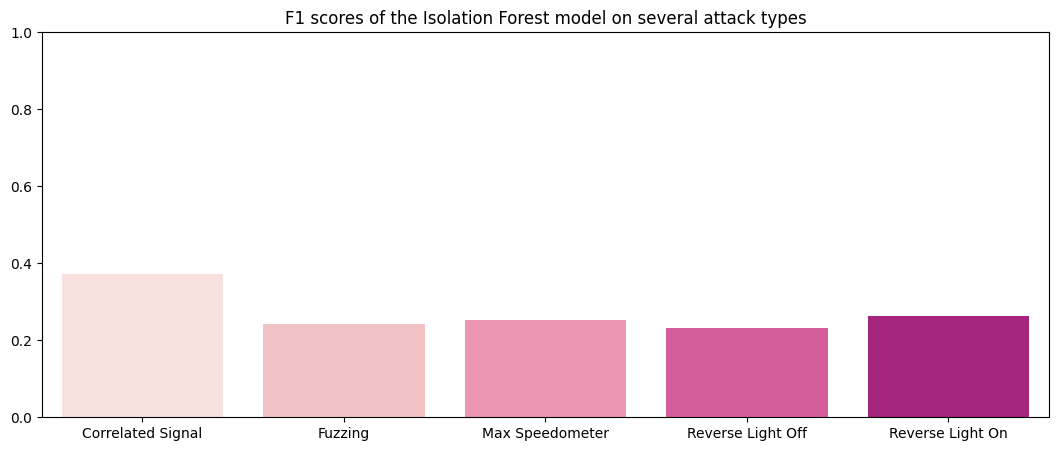

In [ ]:
test_method(model=isof2,
              dset=road_test,
              print_report=False)

Now, let's see how it performs on the holdout set (`road_valid`)

Performance of the Isolation Forest approach on Correlated Signal:
              precision    recall  f1-score   support

           0       0.23      0.76      0.35     16337
           1       0.75      0.22      0.34     53320

    accuracy                           0.35     69657
   macro avg       0.49      0.49      0.35     69657
weighted avg       0.63      0.35      0.35     69657

Predictions for 'Correlated Signal' attack:
Counter({0: 53744, 1: 15913})

Performance of the Isolation Forest approach on Fuzzing:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82     27253
           1       0.19      0.28      0.23      5098

    accuracy                           0.70     32351
   macro avg       0.52      0.53      0.52     32351
weighted avg       0.75      0.70      0.72     32351

Predictions for 'Fuzzing' attack:
Counter({0: 24970, 1: 7381})

Performance of the Isolation Forest approach on Max Speedometer:
              prec

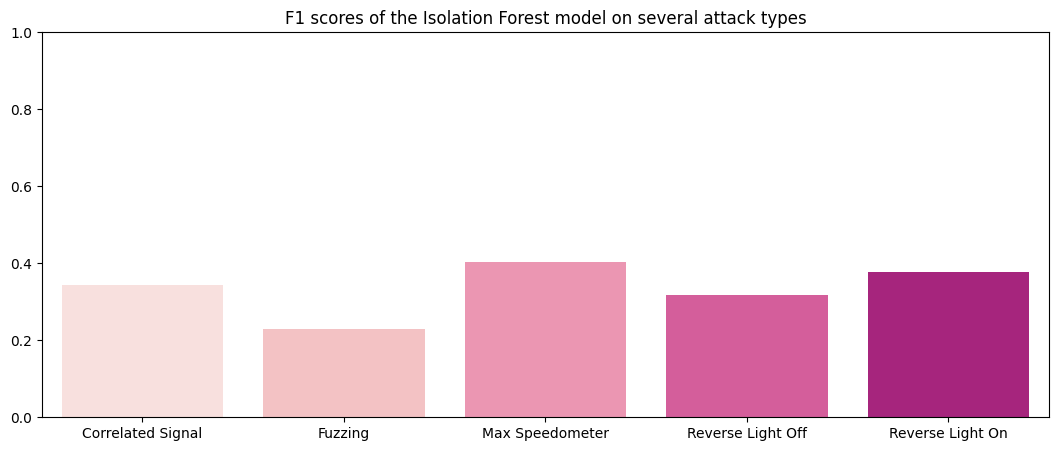

In [ ]:
test_method(model=isof2,
              dset=road_valid,
              print_report=False)

It seems the tuned model is worse, for some reason. How does the original model perform on the validation data?


F1 Scores of the Isolation Forest method:
Correlated Signal   : 0.55719
Fuzzing             : 0.2649
Max Speedometer     : 0.45226
Reverse Light Off   : 0.51073
Reverse Light On    : 0.44284



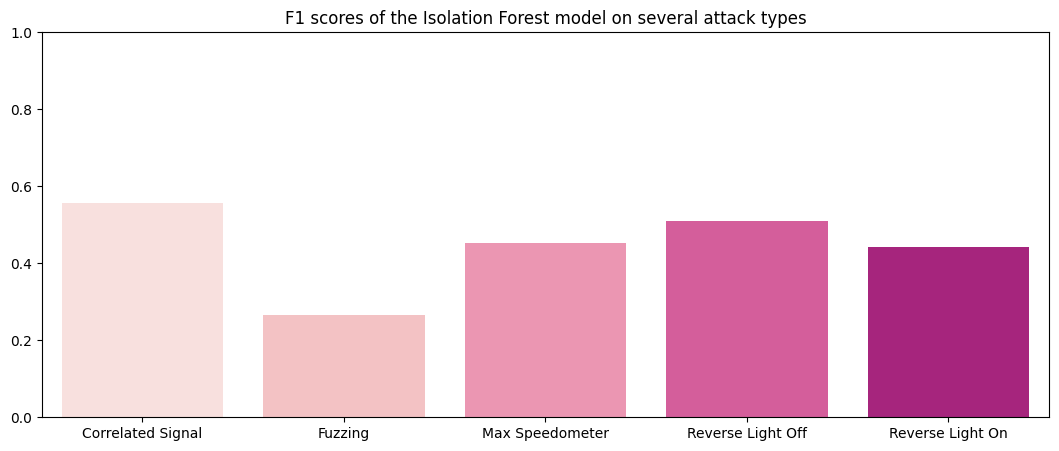

In [ ]:
test_method(model=isof,
            dset=road_valid,
            print_report=True)

Alright, let's go with this for method 2!🥲

## Method 3: Reconstruction Error
Autoencoders are a deep-learning architecture with a quirk: the input and output layers have the same number of neurons, with a bottleneck in between. Basically, they are trained to copy their input to their output. They can be used for several purposes such as compression, image denoising and anomaly detection. To use an autoencoder for anomaly detection, you would train it on normal data and define a threshold on the error of reconstruction to discriminate data it has not seen before. If the error of reconstruction of a data point exceeds that threshold, that data point is an anomaly. Fawaz Waselallah Alsaade and Mosleh Hmoud Al-Adhaileh (2023) employ the autoencoder approach to solve the intrusion detection problem for CAN data.

Let's define the `AutoEncoder` class. The threshold of choice is 3 standard deviations from the mean of errors of reconstruction i.e:
1. Train the autoencoder on normal CAN data
2. Reconstruct the input and obtain the errors of reconstruction, E, as an array/tensor
3. Compute the standard deviation (denoted σ) of the errors
4. Define the threshold as a z-score of 3, or 3σ. Thus if the absolute value of the error, e, is greater than 3 standard deviations from the mean of regular errors, the data point belongs to an attack.

For visual aid, any data point that falls in the 0.1% is determined an attack  
![image](https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg)  
Source: [M. W. Toews](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/600px-Standard_deviation_diagram.svg.png?20150115020654), [CC BY 2.5](https://creativecommons.org/licenses/by/2.5), via Wikimedia Commons



In [ ]:
device = 'cuda:0' if T.cuda.is_available() else 'cpu' # choose the available device

In [ ]:
class AutoEncoder(T.nn.Module):
    def __init__(self, size):
        super().__init__()
        self.fc1 = T.nn.Linear(size, 32)
        self.fc2 = T.nn.Linear(32, 16)
        self.fc3 = T.nn.Linear(16, 32)
        self.fc4 = T.nn.Linear(32, size)
        self.threshold = 0.0
        self.model_name_ = 'Autoencoder'

        # store f1 scores for visualization later
        self.attack_f1 = dict()

    def encode(self, x):
        z = T.tanh(self.fc1(x))
        z = T.tanh(self.fc2(z))
        return z

    def decode(self, x):
        z = T.tanh(self.fc3(x))
        z = T.sigmoid(self.fc4(z))
        return z

    def forward(self, x):
        z = self.encode(x)
        z = self.decode(z)
        return z

    def rec_error(self, data):
        """Compute the reconstruction error when a sample is passed through the autoencoder"""
        # diff = autoenc(T.Tensor(data.values)).detach().numpy() - data.values
        input = T.Tensor(data.values).to(device)
        diff = (self(input) - input).cpu().detach().numpy()
        error = np.mean(np.power(diff, 2), axis=1) # scalar error of reconstruction
        return error

    def set_threshold(self, value):
        self.threshold = value

    def calc_threshold(self, input):
        """Compute the threshold as 3 z-scores from the reconstruction errors of training data"""
        errors = self.rec_error(input) # compute errors of reconstruction

        self.set_threshold(3*np.std(errors))

    def fit(self, input, batch_size, epochs, log_interval, learning_rate):
        # set up loader object
        data_ldr = T.utils.data.DataLoader(T.Tensor(input.values).to(device),
                                        batch_size=batch_size,
                                        shuffle=True)

        loss_func = T.nn.MSELoss() # mean squared error loss
        opt = T.optim.SGD(self.parameters(), lr=learning_rate) # SGD optimizer

        print("\nStarting training")
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0.0 # reset loss
            for (batch_idx, batch) in enumerate(data_ldr):
                X = batch  # inputs
                Y = batch  # targets (same as inputs)

                opt.zero_grad() # prepare gradients
                output = self(X) # compute output/target
                loss_val = loss_func(output, Y) # compute loss/error
                epoch_loss += loss_val.item() # accumulate for display
                loss_val.backward() # compute gradients
                opt.step() # update weights

            if epoch % log_interval == 0:
                print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))

        self.calc_threshold(input) # set the threshold using the training data
        print("Training completed!")

    def detect_anomalies(self, data_X, label, attack_name, print_report=True, return_preds=False):
        """
        Compute reconstruction error. If the error of a message exceeds the threshold
        default of (1 z score), it is predicted as an anomaly
        """

        error = self.rec_error(data_X) # compute error of reconstruction
        preds = np.where(error > self.threshold, 1, 0) # calculate predictions
        if print_report:
            print(f'Performance of the {self.model_name_} on {attack_name} attack:')
            print(classification_report(label, preds))

        self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

        if return_preds: return preds

    def chart_f1(self):
        plt.figure(figsize=(13,5))
        plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
        x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
        sns.barplot(x=x, y=y)
        plt.ylim(ymax=1.0)

The `fit` method sets up the dataloader, loss function, optimizer and runs the training loop for the given number of epochs on the normal data.  
To be able to determine anomalies, a threshold error value will be calculated. Let's define the threshold to be 1 z-score i.e one standard deviation from the mean of errors of reconstruction. A reconstruction with an error exceeding that value is thus an anomaly.

Next, it is important that the autoencoder is just trained on only normal data so it only learns those patterns and not of the anomalies too. The `ROADPrep().train` dataset contains only normal data so it will be used for training.

In [ ]:
input = road_test.train
autoenc = AutoEncoder(size=input.shape[1]).to(device)

Uncomment and run the next cell if you wish to train the autoencoder from scratch and save the weights:

In [ ]:
autoenc.train() # set to train mode

autoenc.fit(input = road_test.train,
            batch_size = 512,
            epochs = 100,
            log_interval = 10,
            learning_rate = 1e-3
            ) # train the model

T.save(autoenc.state_dict(), '../bin/can-autoencoder.pt') # save the model


Starting training


  1%|          | 1/100 [00:05<09:41,  5.87s/it]

epoch =    0   loss = 2571.1686


 11%|█         | 11/100 [01:06<09:05,  6.13s/it]

epoch =   10   loss = 1881.3269


 21%|██        | 21/100 [02:05<07:31,  5.72s/it]

epoch =   20   loss = 1704.3176


 31%|███       | 31/100 [03:01<06:32,  5.69s/it]

epoch =   30   loss = 1580.5871


 41%|████      | 41/100 [03:57<05:31,  5.63s/it]

epoch =   40   loss = 1479.9522


 51%|█████     | 51/100 [04:53<04:30,  5.53s/it]

epoch =   50   loss = 1387.7024


 61%|██████    | 61/100 [05:49<03:35,  5.51s/it]

epoch =   60   loss = 1311.5768


 71%|███████   | 71/100 [06:44<02:37,  5.42s/it]

epoch =   70   loss = 1245.9677


 81%|████████  | 81/100 [07:40<01:42,  5.42s/it]

epoch =   80   loss = 1194.0360


 91%|█████████ | 91/100 [08:37<00:48,  5.43s/it]

epoch =   90   loss = 1160.2945


100%|██████████| 100/100 [09:27<00:00,  5.67s/it]


Training completed!


Otherwise, reload the state dict from prior training and use that for the model. Run the next cell:

In [ ]:
# # load weights
# autoenc.load_state_dict(T.load('../bin/can-autoencoder.pt', map_location=device))

# # set threshold using the train data
# autoenc.calc_threshold(input)

# autoenc.eval() # set to eval mode

Performance of the Autoencoder on Correlated Signal attack:
              precision    recall  f1-score   support

           0       0.36      0.87      0.51     29289
           1       0.64      0.13      0.22     51973

    accuracy                           0.40     81262
   macro avg       0.50      0.50      0.37     81262
weighted avg       0.54      0.40      0.33     81262

Predictions for 'Correlated Signal' attack:
Counter({0: 70379, 1: 10883})

Performance of the Autoencoder on Fuzzing attack:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86     40773
           1       0.22      0.17      0.19      8569

    accuracy                           0.76     49342
   macro avg       0.53      0.52      0.52     49342
weighted avg       0.73      0.76      0.74     49342

Predictions for 'Fuzzing' attack:
Counter({0: 42987, 1: 6355})

Performance of the Autoencoder on Max Speedometer attack:
              precision    recall  f1-s

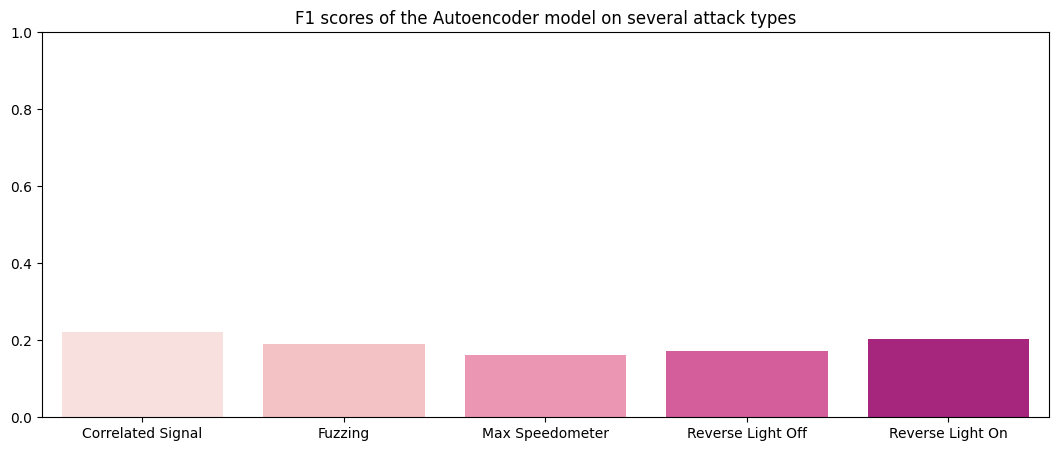

In [ ]:
test_method(model=autoenc,
              dset=road_test,
              print_report=False)

### Improvements
One thing to note here is that there exists a temporal dependency between the signals found in the data features i.e there is a sequence. Perhaps if we switched out the layers in the autoencoder from `Linear` to `LSTM` (a deep learning architecture that captures sequence/dependency), we could observer better results.  
Conveniently, the `sequitur` class provides LSTM-based autoencoders as a class so we can use the library here:

In [ ]:
!pip install sequitur

  Preparing metadata (setup.py) ... done
  Created wheel for sequitur: filename=sequitur-1.2.4-py3-none-any.whl size=9607 sha256=9b085c761b052226c7068699abf8ee3b988eedbe8b9d9161eb29a072d4f4448b
  Stored in directory: /root/.cache/pip/wheels/98/af/0d/45fde9d0819faa8a6d53b85f36576aaf2446b6a57eae68fc27
Successfully built sequitur


In [ ]:
from sequitur.models import LSTM_AE
from sequitur import quick_train

In [ ]:
train_seqs = T.Tensor(road_test.train.values).to(device)
encoder, decoder, _, _ = quick_train(LSTM_AE, train_seqs, encoding_dim=2, denoise=True)

encoder(train_seqs) # => torch.tensor([0.19, 0.84])

IndexError: ignored

In [ ]:
# class AE_LSTM(T.nn.Module):
#     def __init__(self, size, encoding_dim:int, hidden_dims:list[int]):
#         super().__init__()
#         self.encoding_dim = encoding_dim
#         self.hidden_dims = hidden_dims
#         self.model_name_ = 'Autoencoder+LSTM'
#         self.threshold = 0
#         self.model = LSTM_AE(input_dim=size,
#                              encoding_dim=self.encoding_dim,
#                              h_dims=self.hidden_dims,
#                              h_activ=None,
#                              out_activ=None)
#         self.model.__name__ = 'LSTM_AE'
#         self.attack_f1 = dict()

#     def rec_error(self, data):
#         # diff = autoenc(T.Tensor(data.values)).detach().numpy() - data.values
#         input = T.Tensor(data.values).to(device)
#         diff = (self.model(input) - input).cpu().detach().numpy()
#         error = np.mean(np.power(diff, 2), axis=1) # scalar error of reconstruction
#         return error

#     def calc_threshold(self, input):
#         errors = self.rec_error(input) # compute errors of reconstruction
#         self.threshold = 3*np.std(errors) # set threshold to 1 z-score

#     def fit(self, input, epochs, learning_rate):
#         print("\nStarting training")
#         input = T.Tensor(input.values).to(device) # convert to Tensor
#         encoder, decoder, _, losses = quick_train(self.model,
#                                                   input,
#                                                   encoding_dim=self.encoding_dim,
#                                                   lr=learning_rate,
#                                                   epochs=epochs)
#         self.calc_threshold(input) # set the threshold using the training data
#         print("Training completed!")

#     def detect_anomalies(self, data_X, label, attack_name, print_report=True, return_preds=False):
#         error = self.rec_error(data_X) # compute error of reconstruction
#         preds = np.where(error > self.threshold, 1, 0) # calculate predictions
#         if print_report:
#             print(f'Performance of the {self.model_name_} on {attack_name} attack:')
#             print(classification_report(label, preds))

#         self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

#         if return_preds: return preds

In [ ]:
# class AutoEncoderLSTM():
#     def __init__(self, input_dim, encoding_dim, hidden_dims, h_activ=None, out_activ=None):
#         self.input_dim = input_dim
#         self.encoding_dim = encoding_dim
#         self.hidden_dims = hidden_dims
#         self.h_activ = h_activ
#         self.out_activ = out_activ
#         self.model = LSTM_AE(input_dim=self.input_dim,
#                              encoding_dim=self.encoding_dim,
#                              h_dims=self.hidden_dims,
#                              h_activ=None,
#                              out_activ=None).to(device)

#         self.attack_f1 = dict() # store f1 scores for visualization later
#         self.model_name_ = 'Autoencoder(LSTM)'

#     def rec_error(self, data):
#         """Compute the reconstruction error when a sample is passed through the autoencoder"""
#         input = T.Tensor(data.values).to(device)
#         diff = (self.model(input) - input).cpu().detach().numpy()
#         error = np.mean(np.power(diff, 2), axis=1) # scalar error of reconstruction
#         return error

#     def calc_threshold(self, data):
#         """Calculate threshold as 3 * std of train data error"""
#         errors = self.rec_error(data) # compute errors of reconstruction
#         self.threshold = 3*np.std(errors)

#     def fit(self, train_data):
#         print("\nStarting training")
#         input = T.Tensor(train_data.values).to(device)
#         self.encoder, self.decoder, _, _ = quick_train(model,
#                                                        train_data,
#                                                        encoding_dim=self.encoding_dim)
#         self.threshold = self.calc_threshold(input)
#         print('Training complete')

#     def detect_anomalies(self, data, label, attack_name, print_report=True, return_preds=False):
#         # make predictions and print classification
#         error = self.rec_error(data)
#         preds = np.where(error > self.threshold, 1, 0) # transform predictions using {-1:1, 1:0}
#         if print_report:
#             print(f'Performance of the {self.model_name_} approach on {attack_name}:')
#             print(classification_report(label, preds))

#         self.attack_f1[attack_name] = f1_score(label, preds) # store the f1 score

#         if return_preds: return preds

#     def chart_f1(self):
#         plt.figure(figsize=(13,5))
#         plt.title(f'F1 scores of the {self.model_name_} model on several attack types')
#         x, y = list(self.attack_f1.keys()), list(self.attack_f1.values())
#         sns.barplot(x=x, y=y)
#         plt.ylim(ymax=1.0)

In [ ]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
input = road_test.train
autoenc2 = AutoEncoderLSTM(input_dim=input.shape[1], encoding_dim=4, hidden_dims=[8,6])

autoenc2.fit(input) # train the model


Starting training


TypeError: ignored

In [ ]:
test_method(model=autoenc2,
              dset=road_test,
              print_report=False)

how does this new model behave on validation data?

In [ ]:
test_method(model=autoenc2,
              dset=road_valid,
              print_report=False)

## Conclusion
We have seen the results of the three method on anomaly detection. Several other methods exist. Some research papers use Long Short Term Memory (LSTM) and/or ConvNet architecture in place of Autoencoders, message intervals in place of frequency detection, support vectors instead of tree-based estimation and so on. Perhaps it is a good idea to build a classifier? Several roads lead to the market.

One thing that can be improved on in the various method above is hyperparameter tuning for the two machine learning method and a search across different threshold values for the frequency detection method.

__________

# References

Fawaz Waselallah Alsaade, & Mosleh Hmoud Al-Adhaileh. (2023). Cyber Attack Detection for Self-Driving Vehicle Networks Using Deep Autoencoder Algorithms. Sensors, 23(8), 4086–4086. https://doi.org/10.3390/s23084086

Hoppe, T., Kiltz, S., & Dittmann, J. (2011). Security threats to automotive CAN networks—Practical examples and selected short-term countermeasures. Reliability Engineering & System Safety, 96(1), 11–25. https://doi.org/10.1016/j.ress.2010.06.026

Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). Isolation Forest. 2008 Eighth IEEE International Conference on Data Mining, 413–422. https://doi.org/10.1109/icdm.2008.17

Verma, M. E., Iannacone, M. D., Bridges, R. A., Hollifield, S. C., Moriano, P., Kay, B., & Combs, F. L. (2020). Addressing the Lack of Comparability & Testing in CAN Intrusion Detection Research: A Comprehensive Guide to CAN IDS Data & Introduction of the ROAD Dataset. Retrieved August 26, 2023, from arXiv.org website: https://arxiv.org/abs/2012.14600